In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

from pulse_lib.pickle_parse import *
from pulse_lib.phase_calibration import *

from qick import *
import Pyro4
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ


In [564]:
# Import dictionary of sequences from pickle file
import pickle
# with open('pulse_sequences/Sequence_ch1_ch2_mw.pickle', 'rb') as handle:
#     imported_sequences = pickle.load(handle)

# for key, value in imported_sequences.items():
#     print(key, value)

imported_sequences = {}
imported_sequences["MW"] = [(1000, 1.0, 0.1, 0)]
imported_sequences["DIG"] = [(1000, 1)]

In [565]:
# Gain and delay defaults are specified - not necessary to assign individually
# Multiplicative gain for DAC amplitudes
gains = {"DAC_A": 20000,
         "DAC_B": 20000
         }

# Channel trigger delays for synchronisation
delays = {"DAC_A": -38,
          "DAC_B": -38,
          "DIG_0": 0
          }

# Method 1: use if keys don't match channel names
ch_map={"DAC_A": "MW",
        "DAC_B": "MW",
        "DIG_0": "DIG",
        # "DIG_1": "ch1_Dig"
        }

pulse_sequences = PickleParse(imported_sequences,
                              ch_map=ch_map,
                              gains=gains,
                            #   delays=delays
                              )

# Method 2: use if channel names already configured (uncomment block below)
# renamed_sequences = {}
# renamed_sequences["DAC_A"] = imported_sequences["MW"]
# renamed_sequences["DIG_0"] = imported_sequences["ch2_Dig"]
# renamed_sequences["DIG_1"] = imported_sequences["ch1_Dig"]

# pulse_sequences = PickleParse(renamed_sequences)

----- DAC A -----
ch_type: DAC
ch_index: 1
delay: 0
gain: 20000
lengths: [1.0]
times: [0.0]
amps: [1.0]
freqs: [100.0]
phases: [0]
num_pulses: 1
duration: 1.0
----- DAC B -----
ch_type: DAC
ch_index: 0
delay: 0
gain: 20000
lengths: [1.0]
times: [0.0]
amps: [1.0]
freqs: [100.0]
phases: [0]
num_pulses: 1
duration: 1.0
----- DIG 0 ------
ch_type: DIG
ch_index: 0
delay: 0
lengths: [1.0]
times: [0.0]
num_pulses: 1
duration: 1.0
----- End time: 1.0 -----


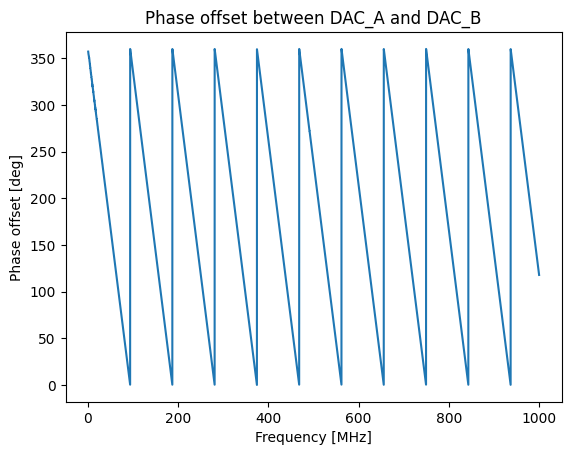

In [857]:
# FIXME: Don't like how this is relying on the order of the lists to work

# TODO: UNITS???
# DELAY = -32e-5 # Change this to compensate for mismatched cable lengths etc.
# DELAY = -36e-5
DELAY = 0

delta_phis = {}

# to read the data
with open('calibrate_phase.pickle', 'rb') as handle:
    res = pickle.load(handle)

for freq in res:
    phase_delay = 360 * freq * DELAY
    # delta_phis[dac_freqs[i]] = [((res[i][0][0] - res[i][1][0]) % 360) - phase_delay, 0] 
    # delta_phis[i] = [((res[i][0][0] - res[i][1][0]) % 360), 0] 
    delta_phis[freq] = [((res[freq][0] - res[freq][1]) - phase_delay) % 360, 0]

x,y = [], []
for key, value in delta_phis.items():
    # print(f"{key}: {value[0]}")
    x.append(key)
    y.append(value[0])

# plt.plot(x,y, marker="s")
plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

In [858]:
# Create program object
prog = QickProgram(soccfg)

# Method 1 - Run, specifying number of repetitions
pulse_sequences.generate_asm(prog, delta_phis, reps=2)
# pulse_sequences.generate_asm(prog, reps=2)

# Method 2 - Run with no repetitions
# raman_cooling.generate_asm(prog, gain=10000)

In [973]:
# Load assembly to board
prog.config_all(soc)

# Run program
soc.tproc.start() 

# Useful for debugging synchronisation issues
print(prog)


// Program

        synci 200;
        regwi 0, $14, 1;
LOOP_I: regwi 1, $22, 43690667;                 //freq = 43690667
        regwi 1, $23, 0;                        //phase = 0
        regwi 1, $25, 20000;                    //gain = 20000
        regwi 1, $26, 590438;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 614 
        regwi 1, $27, 0;                        //t = 0
        set 1, 1, $22, $23, $0, $25, $26, $27;  //ch = 1, pulse @t = $27
        regwi 0, $22, 43690667;                 //freq = 43690667
        regwi 0, $23, 1004306270;               //phase = 4017225081
        bitwi 0, $23, $23 << 2;
        mathi 0, $23, $23 + 1;
        regwi 0, $25, 20000;                    //gain = 20000
        regwi 0, $26, 590438;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 614 
        regwi 0, $27, 0;                        //t = 0
        set 0, 0, $22, $23, $0, $25, $26, $27;  //ch = 0, pulse @t = $27
        regwi 0, 